In [0]:
#imports

import keras
keras.__version__
import pandas as pd
import copy
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential 
from keras.layers import Dense

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score



Using TensorFlow backend.


In [0]:
!pip install -q xlrd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#uploading excel file with data


dfferdig = pd.read_excel("drive/My Drive/DAT300/fullgraminor2018.xlsx", sheet_name=0)

#df = pd.read_excel("drive/My Drive/DAT300/combinedfirstwest(varhvete-b).xlsx", sheet_name=0)
#df2 = pd.read_excel("drive/My Drive/DAT300/combinedfirsteast(varhvete-b).xlsx", sheet_name=1)
#df = pd.read_excel("drive/My Drive/DAT300/combinedseconwest.xlsx", sheet_name='13-07-18')
#df2 = pd.read_excel("drive/My Drive/DAT300/combinedsecondeast(masbasis).xlsx", sheet_name='13-07-18')
#!ls "drive/My Drive/DAT300/combinedfirsteast(varhvete-b).xlsx"
#dfferdig = df.append(df2, ignore_index=False)
dfferdig.set_index('26-06-18Unnamed: 0', inplace=True)
dfferdig.dropna(axis=0, subset=['26-06-18GrainYield'], inplace=True)

#dfferdig= pd.read_excel("drive/My Drive/DAT300/fullfirst.xlsx")
#dfferdig.index.is_unique
#dfferdig = dfferdig[dfferdig.GrainYield != -9]



In [0]:
#Setting the features used for the deep learning, mostly spectral values from different dates

#features = ['26-06-18_bluemedian', '26-06-18_greenmedian','26-06-18_redmedian', '26-06-18_ndvimedian', 
#          '26-06-18_nirmedian', '26-06-18_rededgemedian', '26-06-18_mtci', '26-06-18_evi', 'MAT',
#          '02-07-18_bluemedian', '02-07-18_greenmedian','02-07-18_redmedian', '02-07-18_ndvimedian', 
#          '02-07-18_nirmedian', '02-07-18_rededgemedian', '02-07-18_mtci', '02-07-18_evi',
#          '19-07-18_bluemedian', '19-07-18_greenmedian','19-07-18_redmedian', '19-07-18_ndvimedian', 
#          '19-07-18_nirmedian', '19-07-18_rededgemedian', '19-07-18_mtci', '19-07-18_evi', 
features = ['26-06-18_bluemedian', '26-06-18_redmedian', '26-06-18_mtci', 'MAT',	
       '02-07-18_mtci', '02-07-18_evi', '19-07-18_bluemedian',	
       '19-07-18_greenmedian', '19-07-18_redmedian', '19-07-18_nirmedian',	
       '19-07-18_mtci']



df_x = dfferdig[features]
df_y = dfferdig['26-06-18GrainYield']



In [0]:
df_x.shape

(599, 11)

In [0]:
#Scaling the data

scaler= StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
        df_x, df_y, test_size=0.3, random_state=1)
X_train.iloc[:, :] = scaler.fit_transform(X_train)
X_test.iloc[:, :] = scaler.transform(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist

In [0]:
#Function for creating model

def build_model(act, lay, nur):
    
    # Input: 
    #     act: which activations function, denoted by 'name_of_activation' i.e. 'relu'
    #     lay: integer, number of layers 
    #     nur: number of neurons within each layer. possibly we would want a different number of neurons per layer within a model. 
    #          but for now we keep the same number of neurons for all layers
    
    model = Sequential()
    model.add(Dense(nur, activation=act, input_shape=(X_train.shape[1],)))
    n=1
    while n <= lay:
      model.add(Dense(nur, activation=act))
      n += 1
    
    model.add(Dense(1, activation=act))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [0]:
#K-fold function to train the model

def K_fold(X_train, y_train, model_activation, model_layers, model_neurons, k, num_epochs, history=False):
  """Custom function for K-fold Cross validation for both keras 
  Inspired by the Colab notebook 'DAT300 - 05 - regression example.ipynb'"""
  
  num_val_samples = X_train.shape[0] // k
  all_scores = np.zeros(k)
  all_mae_histories = []

  for i in range(k):
      print('processing fold #', i+1)

      # Prepare the validation data: data from partition # k
      val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
      val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

      # Prepare the training data: data from all other partitions
      partial_train_data = np.concatenate(
          [X_train[:i * num_val_samples],
           X_train[(i + 1) * num_val_samples:]],
          axis=0)

      partial_train_targets = np.concatenate(
          [y_train[:i * num_val_samples],
           y_train[(i + 1) * num_val_samples:]],
          axis=0)

      # Build the Keras model (already compiled)
      model = build_model(model_activation, model_layers, model_neurons)

      # Train the model (in silent mode, verbose=0)
      history = model.fit(partial_train_data, partial_train_targets,
                          validation_data=(val_data, val_targets),
                          epochs=num_epochs, batch_size=1, verbose=0)

      # Evaluate the model on the validation data
      val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
      all_scores[i] = val_mae
      
      mae_history = history.history['val_mean_absolute_error']
      all_mae_histories.append(mae_history)
  
  average_mae_history = [
      np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
  print(min(average_mae_history))
  if history:
    return average_mae_history
  else:
    return all_scores

In [0]:
#function for plotting the curve for results using different number of epochs

def plot_epochs(mae_history, title):
  plt.plot(range(1, len(mae_history) + 1), mae_history)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Validation MAE')
  plt.show()
  

## result table


In [0]:
#creating a result-table, this doesnt get much use

K_fold_results = pd.DataFrame({'Model': ['ReLU','Deep ReLU','selu', 'Deep selu', 'LinReg Quadratic', 'LinReg Cubic'],
                      'Validation MAE': np.nan,
                      'Hyperparameters': np.nan})
K_fold_results.set_index('Model', inplace=True)
K_fold_results = K_fold_results[['Validation MAE', 'Hyperparameters']]

K_fold_results

,Validation MAE,Hyperparameters
Model,,
ReLU,NaN,NaN
Deep ReLU,NaN,NaN
selu,NaN,NaN
Deep selu,NaN,NaN
LinReg Quadratic,NaN,NaN
LinReg Cubic,NaN,NaN


## From now I try different activation functions with different depths

## ReLU

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
173.37423248291014
173.37423248291014


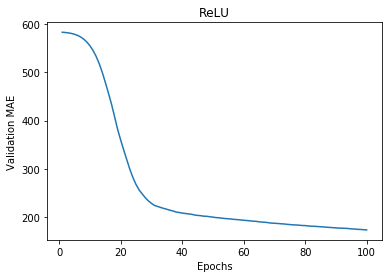

In [0]:


relu_layers = 2
relu_neurons = 8
relu_history = K_fold(X_train=X_train, y_train=y_train, model_activation='relu', model_layers=relu_layers, model_neurons=relu_neurons, k=10, num_epochs=100, history=True)
print(min(relu_history))
plot_epochs(relu_history, 'ReLU')

## Deep ReLU

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
63.13377583821615


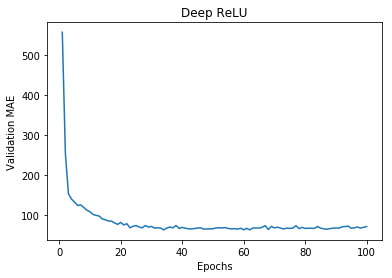

In [0]:
deep_relu_layers = 5
deep_relu_neurons = 32
deep_relu_history = K_fold(X_train=X_train, y_train=y_train, model_activation='relu', model_layers=deep_relu_layers, model_neurons=deep_relu_neurons, k=10, num_epochs=100, history=True)

plot_epochs(deep_relu_history, 'Deep ReLU')

## Selu

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
52.65763295491537


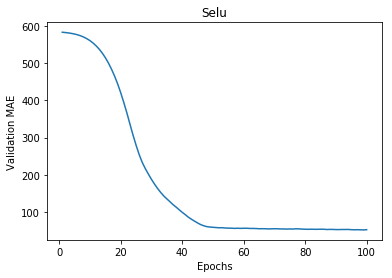

In [0]:
selu_layers = 2
selu_neurons = 8
selu_history = K_fold(X_train=X_train, y_train=y_train, model_activation='selu', model_layers=selu_layers, model_neurons=selu_neurons, k=10, num_epochs=100, history=True)

plot_epochs(selu_history, 'Selu')

## deep selu


processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10
42.021051025390626


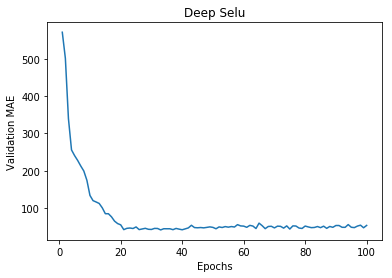

In [0]:
deep_selu_layers = 5
deep_selu_neurons = 32
deep_selu_history = K_fold(X_train=X_train, y_train=y_train, model_activation='selu', model_layers=deep_selu_layers, model_neurons=deep_selu_neurons, k=10, num_epochs=100, history=True)

plot_epochs(deep_selu_history, 'Deep Selu')

## Linear regression

In [0]:
# Linear
LinReg_lin_score = cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
K_fold_results.loc['LinReg', :] = [abs(np.mean(LinReg_lin_score)), ' ']

# Quadratic
X_quad = PolynomialFeatures(degree=2).fit_transform(X_train)
LinReg_quad_score = cross_val_score(LinearRegression(), X_quad, y_train, cv=5, scoring='neg_mean_absolute_error')
K_fold_results.loc['LinReg Quadratic', :] = [abs(np.mean(LinReg_quad_score)), ' ']

# Cubic
X_cubic = PolynomialFeatures(degree=3).fit_transform(X_train)
LinReg_cub_score = cross_val_score(LinearRegression(), X_cubic, y_train, cv=5, scoring='neg_mean_absolute_error')
K_fold_results.loc['LinReg Cubic', :] = [abs(np.mean(LinReg_cub_score)), ' ']

In [0]:
K_fold_results

,Validation MAE,Hyperparameters
Model,,
ReLU,NaN,NaN
Deep ReLU,NaN,NaN
selu,NaN,NaN
Deep selu,NaN,NaN
LinReg Quadratic,44.506143,
LinReg Cubic,69.548753,
LinReg,37.116947,


## Setting best models

In [0]:
bestdeep = build_model(act='selu', lay=5, nur=32)
bestdeep.fit(X_train, y_train, epochs=49, batch_size=1, verbose=0)

#bestdeep.predict(X_test)
bestdeep.evaluate(X_test, y_test, batch_size=1)

180/180 [==============================] - 0s 2ms/step


[1374.051100186031, 28.84810528225369]

In [0]:
bestdeep.metrics_names

['loss', 'mean_absolute_error']

In [0]:
bestlin = PolynomialFeatures(degree=3).fit_transform(X_test)
lin_score = cross_val_score(LinearRegression(), bestlin, y_test, cv=5, scoring='neg_mean_absolute_error')
K_fold_results.loc['LinReg Cubic', :] = [abs(np.mean(lin_score)), ' ']

In [0]:
K_fold_results

,Validation MAE,Hyperparameters
Model,,
ReLU,NaN,NaN
Deep ReLU,NaN,NaN
selu,NaN,NaN
Deep selu,NaN,NaN
LinReg Quadratic,48.309287,
LinReg Cubic,49.004899,
LinReg,38.937873,
